## Chapter 14: Tree-based learners

# 14.7 Cross-Validation Techniques for Recursively Defined Trees

You can toggle the code on and off in this presentation via the button below.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

The basic principles of cross-validation, outlined in Sections 11.2 - 11.4, apply to the proper use of regression and classification trees as well.  That is, we use *validation error* as the measurement tool of choice to determine a tree-structure (a model with just the right capacity) that will represent a dataset as well as possible.  Moreover we can - in general - start the search for the right structure / capacity by beginning with either a low capacity / simple tree and gradually *increasing* its complexity or by likewise starting with an overly complex / high capacity tree and *decreasing* its capacity until we attain a minimum validation model.  Due to the the recursive way trees are built the latter approach - generally called regularization (see Section 11.4) - is more commonly employed with trees.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
 
# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

##  Early stopping

- We can easily use cross-validation to dictate the proper maximum depth of a tree by growing a tree of large depth, measuring validation error at each depth of the tree, and (after the fact) determine which depth produced minimal validation error. 

- Alternatively, we can stop the growth early when we are confident that (something approximating) minimum validation error has been achieved.

- This approach, while used in practice, translates to a relatively coarse model search since the capacity of a tree grows exponentially from one depth to the next.

Practical considerations are often used to halt the leaf splitting, including halting splitting:

- if a leaf contains a singleton data point or a pre-decided (small) number of points
- if all data points belong to the same class (in the case of classification)
- if all data points have approximately the same output value (in the case of regression)

- To create a finer-resolution cross-validation search we can add validation-error-focused criteria to halt the growth of individual leaves as well.

- The simplest such criterion is to check whether or not splitting a leaf will result in lowering validation error (or lowering training error past a predetermined threshold): if yes, the leaf is split, otherwise growth of the leaf is halted. 

- This approach to cross-validation is unique in that validation error will always monotonically decrease as the maximum depth of a tree is increased, but can result in underfitting models due to leaves halting growth prematurely.

As with any universal approximator type we can accomplish a rather coarse cross-validation by simply taking a set trees of various different maximum depths and choosing the best one based on minimal validation error.  However because a tree of maximum depth $D$ is transformed into a tree of maximum depth $D+1$ by splitting each of its leaves (that allow for splitting), with trees a 'set of various maximum depth trees' is really just a single tree grown to various maximum depths.  Because of this simple cross-validation is often thought of with trees as a form of 'early-stopping', that is (at least ideally) we *stop* the growth of the tree *early* when its validation error is minimal (otherwise we simply try out a range of maximum depths and choose the validation error minimizing depth afterwards).  

Below we show an example of cross-validating the maximum depth of a tree in the range of $1$ to $7$ for a simple regression dataset:

- training data/error: blue
- validation data/error: yellow


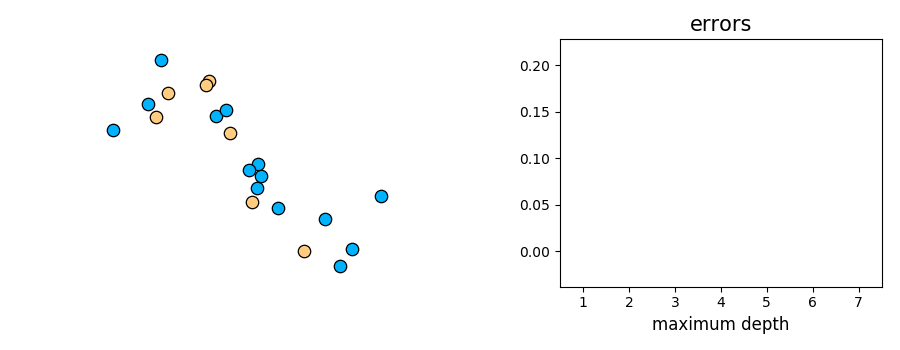
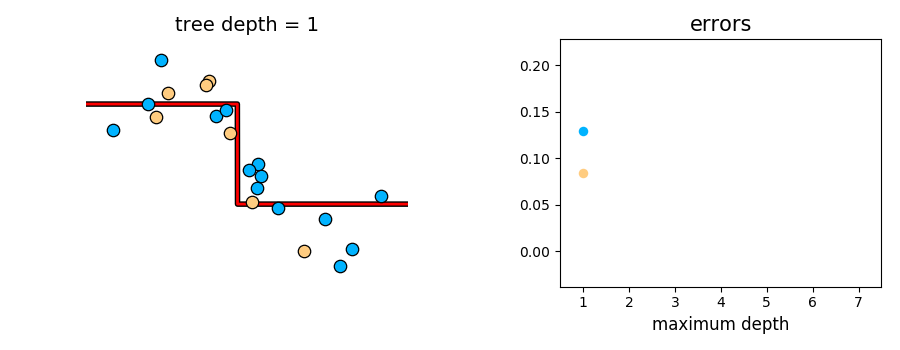
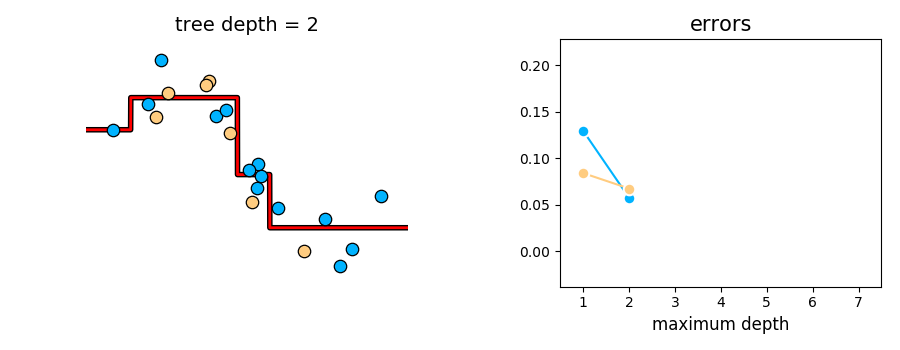
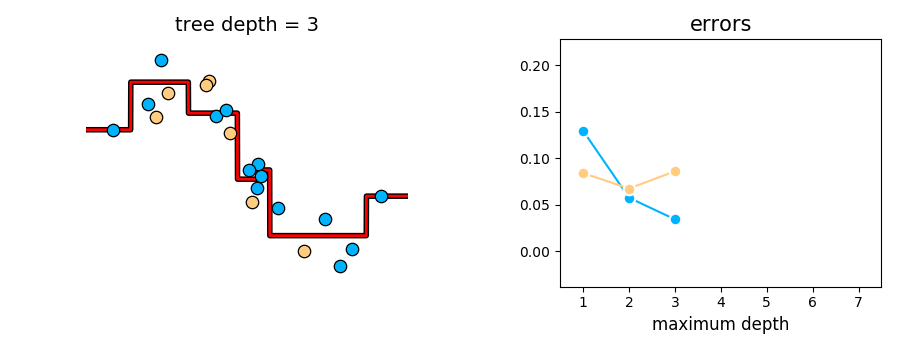
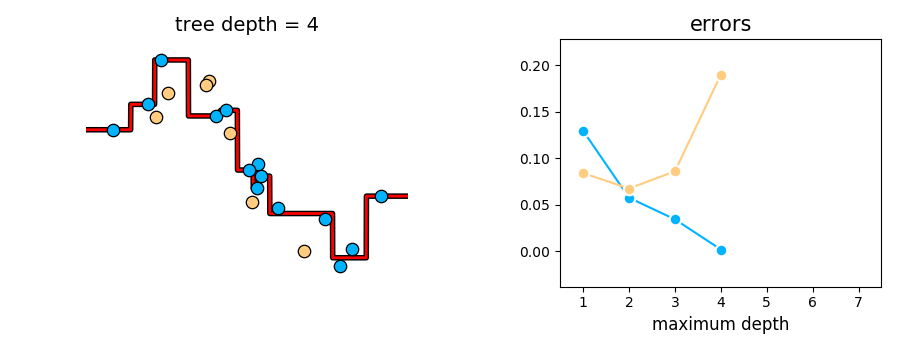
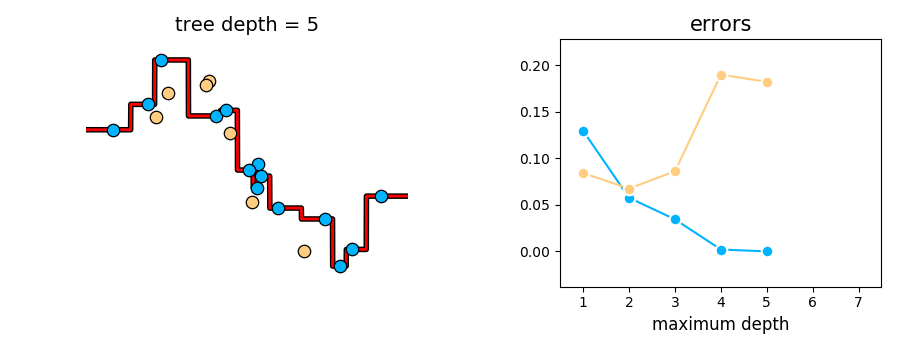
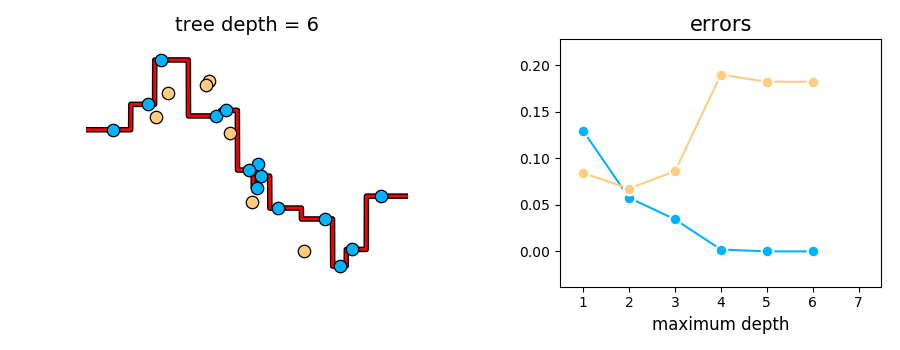
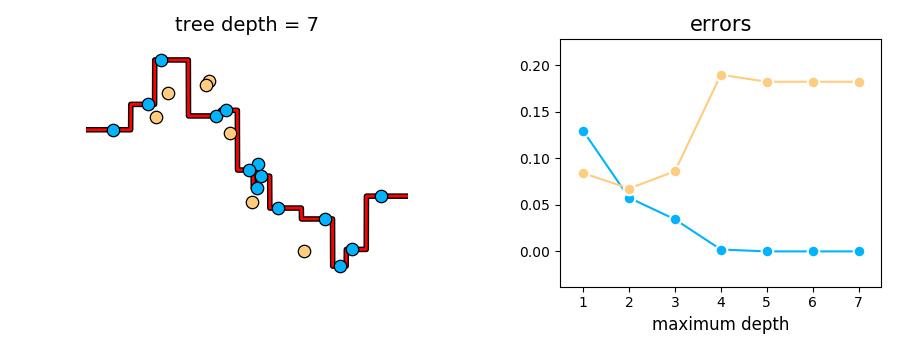

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# create root stump
csvname = datapath + 'noisy_sin_sample.csv'
depth = 7
tree = nonlib.recursive_tree_lib_crossval.RegressionTree.RTree(csvname,depth,train_portion = 0.66)

# animate
demo = nonlib.recursive_tree_lib_crossval.regression_animator.Visualizer(csvname)
demo.animate_trees(tree)

As with any form of 'early-stopping', whether it be when increasing or decreasing the capacity of a model (as is commonly done with neural networks - as detailed in Section 13.6), determining when validation error is at its minimum 'on the fly' is not easy, and usually a heursitic is applied like 'check if the next two models have smaller validation error' before halting.  

However, again, such a cross-validation can be remarkably *coarse* given the potentially drastic difference in capacity between subsequent depth trees.  As noted in Section 14.1, a depth $D$ tree has $2^D$ leaves - thus the capacity difference between subsequent maximum depth trees is potentially *exponential*.  However when used in concert with other natural and heuristic choices for stopping leaf growth mentioned in the previous Sections - e.g., not splitting leaves containing all members of the same class (in the case of classification), not splitting leaves that contain a minimum number of points, etc., - this form of cross-validation can be effective in practice.  

##  Pruning

- In contrast to beginning with a low-capacity (shallow) tree and growing it via early stopping, we can instead begin by fitting a high-capacity (deep) tree and remove leaves that do not improve validation error, until a minimum-validation tree structure remains.

- This technique is called pruning because it entails examining an initially overly complicated tree and cutting off its leaves.

- While early stopping is often more computationally efficient than pruning, the latter provides a finer-resolution model search in determining the tree structure with minimal validation error, since tree/leaf growth is unhindered and is only cut back after the fact.

We can also start with an overly complex (high capacity) deep tree and block its capacity via *regularization* techniques (see Section 11.4) until achieving a validation error minimizing tree.  In the context of trees, regularization is often referred to as *pruning* since it entails examining an initially overly complicated tree and cutting off leaves that improve validation error.  Often, as shown figuratively below, this entails beginning at the *terminal* nodes of a tree and systematically removing those that improve validation error.

<img src= '../../mlrefined_images/nonlinear_superlearn_images/pruning.png' width="75%" alt=""/> 
Pruning illustrated. (top panels) A fully-grown tree of depth two with four leaves. (bottom) A pruned version of the original tree.   
